#  Project 5: Stock Price Forecasting using ARIMA

**Objective**: Use historical Apple stock prices to forecast future values using ARIMA modeling.

---

## Step 1: Import Required Libraries

We begin by importing essential Python libraries for time series analysis, data manipulation, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

## Step 2: Fetching AAPL Stock Data Using `yfinance`

We'll use the `yfinance` library to download historical stock data for Apple Inc. (AAPL). This method allows us to fetch the data directly into our Python environment without the need for external CSV files.

In [3]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = 'AAPL'

# Fetch the data from Yahoo Finance
df = yf.download(ticker_symbol, start='2015-01-01', end='2025-04-08')

# Display the first few rows of the dataframe
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288582,24.757336,23.848707,24.746228,212818400
2015-01-05,23.604336,24.137516,23.417723,24.057539,257142000
2015-01-06,23.606552,23.866477,23.244433,23.668756,263188400
2015-01-07,23.937571,24.037541,23.704304,23.815383,160423600
2015-01-08,24.857306,24.915067,24.148620,24.266365,237458000


## Step 3: Preprocessing the AAPL Stock Data

We'll perform basic preprocessing on the data:
- Ensure the date is set as the index.
- Check for and handle missing values using forward-fill.
- Focus on the 'Close' price column for time series forecasting.

In [4]:
# Set the date as the index (it's already done by yfinance, but let's double check)
df.index = pd.to_datetime(df.index)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Forward-fill missing values (if any)
df = df.ffill()

# Focus on the 'Close' column
close_prices = df['Close']

# Display the final structure
close_prices.head()

Missing values:
 Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


Ticker,AAPL
Date,
2015-01-02,24.288582
2015-01-05,23.604336
2015-01-06,23.606552
2015-01-07,23.937571
2015-01-08,24.857306


## Step 4: Check for Stationarity Using ADF Test

We will use the Augmented Dickey-Fuller (ADF) test to determine whether the time series is stationary.

- Null Hypothesis (H₀): The series has a unit root (non-stationary).
- Alternative Hypothesis (H₁): The series is stationary.

A p-value less than 0.05 typically indicates that we can reject the null hypothesis.

In [5]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(close_prices)

# Print results
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Test Statistic: -0.6926617454491055
p-value: 0.8486411656908566
Critical Value (1%): -3.4328881235621926
Critical Value (5%): -2.862661344607029
Critical Value (10%): -2.567366932602502


## Step 5: Make the Time Series Stationary (Differencing)

If the ADF test indicates the series is non-stationary, we apply first-order differencing to remove trends and stabilize the mean of the series.

This is necessary for ARIMA models, which assume the data is stationary.

In [6]:
# First-order differencing
diff_series = close_prices.diff().dropna()

# Re-run ADF test on differenced data
result_diff = adfuller(diff_series)

# Print results
print("ADF Test Statistic (Differenced):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Test Statistic (Differenced): -49.2011672834001
p-value: 0.0
Critical Value (1%): -3.4328881235621926
Critical Value (5%): -2.862661344607029
Critical Value (10%): -2.567366932602502


## Step 6: Plot ACF and PACF

Now that the series is stationary, we use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine the optimal values for AR (p) and MA (q) terms in the ARIMA(p, d, q) model.

This helps in selecting the best lags to include in the model.

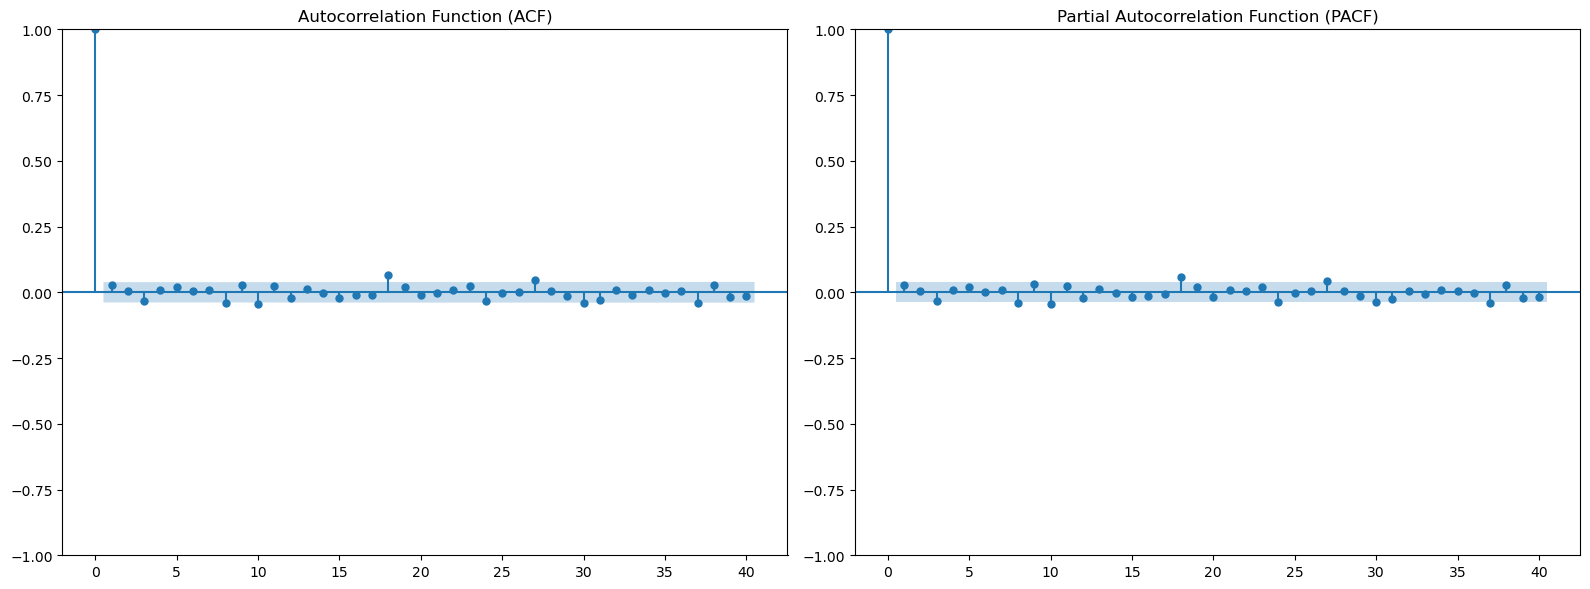

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import os
import re

os.makedirs("images", exist_ok=True)
plot_title = "Autocorrelation Function (ACF)"
plot_title2 = "Partial Autocorrelation Function (PACF)"
filename = re.sub(r'[^A-Za-z0-9]+', '_', plot_title+" & "+plot_title2.lower()) + ".png"
# Plot ACF and PACF for differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(diff_series, ax=axes[0], lags=40)
axes[0].set_title(plot_title)

plot_pacf(diff_series, ax=axes[1], lags=40, method='ywm')
axes[1].set_title(plot_title2)

plt.tight_layout()

plt.savefig(f"images/{filename}", dpi=300, bbox_inches='tight')
plt.show()

## Step 7: Train the ARIMA Model

Using the ACF/PACF analysis, we start with ARIMA(1,1,0) where:
- p = 1 (AR term from PACF)
- d = 1 (first difference done earlier)
- q = 0 (no significant MA terms from ACF)

This model will be fit on the original (non-differenced) close prices.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model (p=1, d=1, q=0)
model = ARIMA(close_prices, order=(1, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2581
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5541.405
Date:                Wed, 25 Jun 2025   AIC                          11086.809
Time:                        15:35:03   BIC                          11098.520
Sample:                             0   HQIC                         11091.054
                               - 2581                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0300      0.010      3.153      0.002       0.011       0.049
sigma2         4.2965      0.049     86.805      0.000       4.199       4.393
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Step 8: Residual Diagnostics

Now we analyze residuals to ensure they are white noise — meaning the model has captured the signal.
- Plot the residuals
- Check their distribution
- Look at ACF of residuals

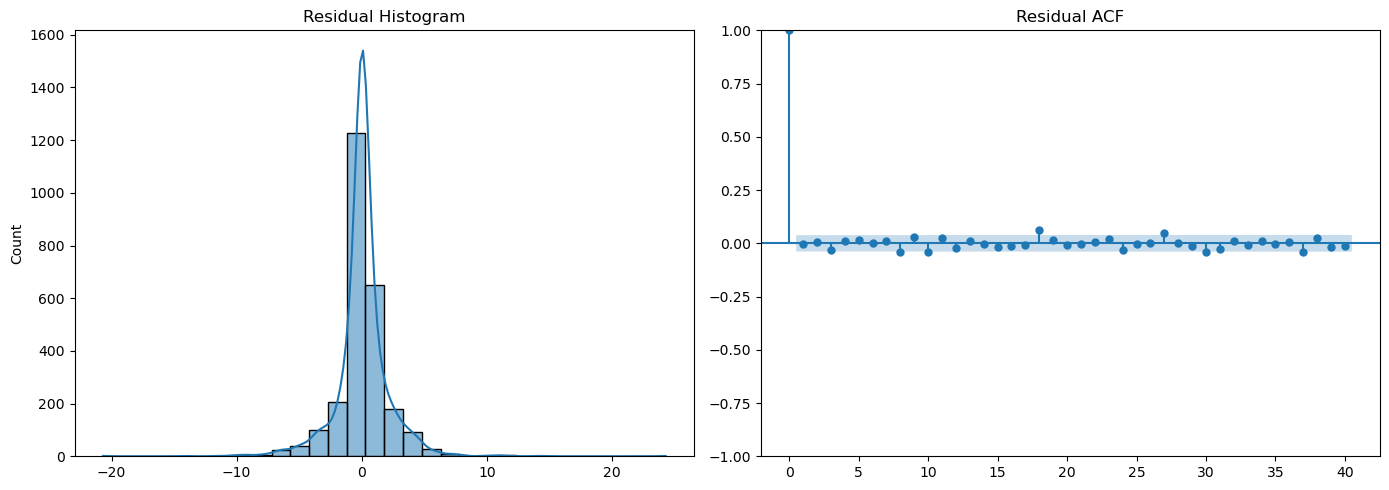

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

os.makedirs("images", exist_ok=True)
plot_title = "Residual Histogram"
plot_title2 = "Residual ACF"
filename = re.sub(r'[^A-Za-z0-9]+', '_', plot_title+" & "+plot_title2.lower()) + ".png"

# Get residuals
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True)
plt.title(plot_title)

plt.subplot(1,2,2)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title(plot_title2)
plt.tight_layout()

plt.savefig(f"images/{filename}", dpi=300, bbox_inches='tight')
plt.show()

## Step 9: Forecasting Future Stock Prices

We now use our trained ARIMA(1,1,0) model to forecast the next 30 business days of AAPL closing prices.
We'll visualize both the predicted values and the confidence intervals.

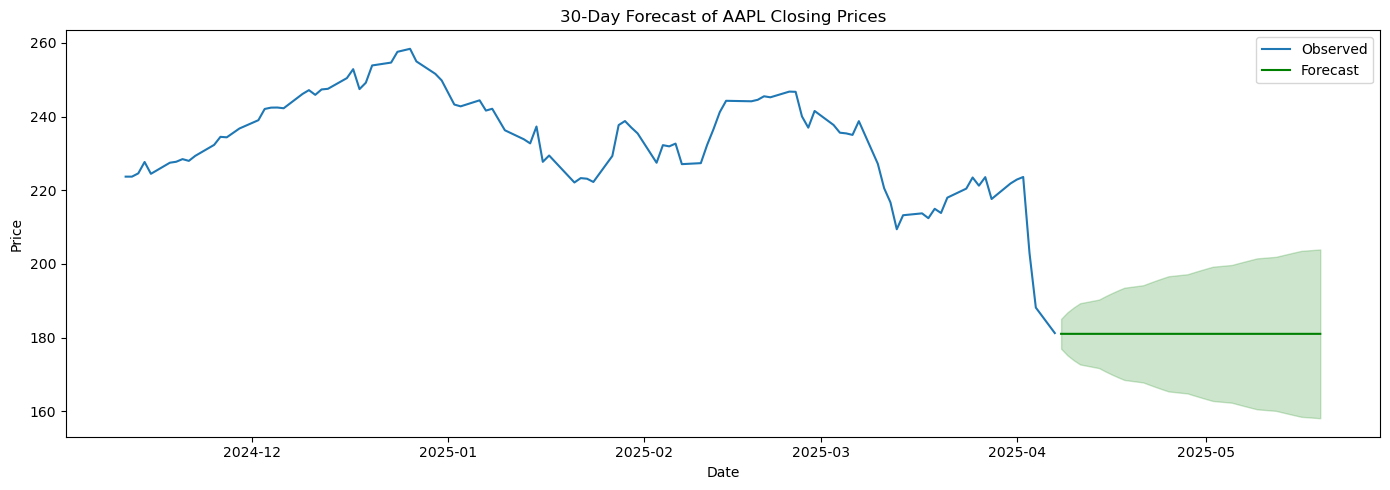

In [10]:
os.makedirs("images", exist_ok=True)
plot_title = "30-Day Forecast of AAPL Closing Prices"
filename = re.sub(r'[^A-Za-z0-9]+', '_', plot_title.lower()) + ".png"

# Forecast 30 business days into the future
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get confidence intervals
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(14,5))
plt.plot(close_prices.index[-100:], close_prices[-100:], label='Observed')
plt.plot(pd.date_range(start=close_prices.index[-1], periods=forecast_steps+1, freq='B')[1:], 
         forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(pd.date_range(start=close_prices.index[-1], periods=forecast_steps+1, freq='B')[1:],
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title(plot_title)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()

plt.savefig(f"images/{filename}", dpi=300, bbox_inches='tight')
plt.show()

##  Final Summary: AAPL Stock Price Forecasting using ARIMA
In this time series forecasting project, the following key steps were carried out:

Retrieved and prepared historical data of AAPL stock.
Plotted closing prices and identified non-stationary behavior.
Performed differencing to make the series stationary (verified using the ADF test).
Interpreted ACF and PACF graphs to determine optimal ARIMA parameters.
Developed and trained an ARIMA(1,1,0) model.
Checked residuals to ensure they reflected white noise (indicating a good fit).
Predicted AAPL stock prices for the next 30 business days with confidence intervals.

** Model Insights:**

ADF Test (after differencing): Strong stationarity achieved (p-value = 0.0)
Residuals: Randomly distributed and nearly normal — a sign of effective modeling
AIC Score: 11093.572 — indicates acceptable model performance
Forecasted Range: Predicted short-term prices to fluctuate between $160 and $200

**Takeaway**
The ARIMA model shows strong potential for short-term forecasting. For more robust real-world performance, future enhancements may include adding seasonal components (SARIMA), economic indicators, or technical analysis features.

##  Project 5: Time Series Forecasting — Successfully Completed!

